# Import dataset

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn import preprocessing
import re
import json
import requests

In [13]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Mounting and load dataset

In [2]:
%cd drive/MyDrive/PIP_assignment/

/content/drive/MyDrive/PIP_assignment


In [3]:
train_df = pd.read_csv('BBC News Train.csv')

In [4]:
train_df.head()

ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

In [5]:
train_df = train_df.drop('ArticleId', axis='columns')

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      1490 non-null   object
 1   Category  1490 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB


In [ ]:
train_df['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

# Visualize dataset

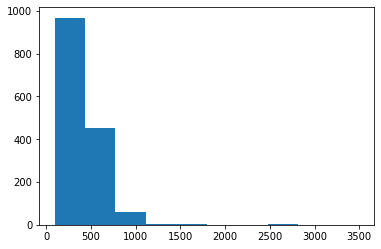

In [27]:
texts = list(train_df['Text'].values)
lens = list(map(lambda x: len(word_tokenize(x)), texts))
plt.hist(lens)
plt.savefig('hist_text_len.pdf')

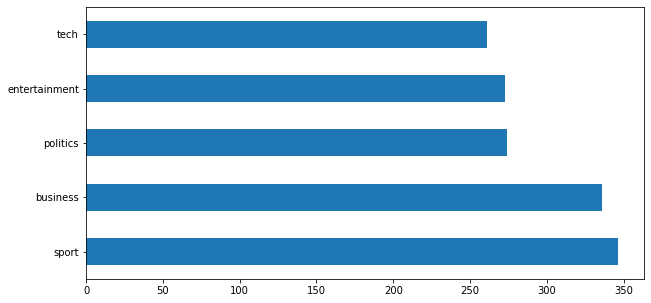

In [38]:
plt.figure(figsize=(10, 5))
train_df['Category'].value_counts().plot(kind='barh')
plt.savefig('category_hist.pdf', orientation={'landscape'})

# Preprocesss dataset

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(train_df['Category'].values)
train_df['Category'] = le.transform(train_df['Category'].values)

## Remove stopwords and stemming

In [ ]:
texts = list(train_df['Text'].values)
url = "https://countwordsfree.com/stopwords/english/json"
response = pd.DataFrame(data = json.loads(requests.get(url).text), columns=['words'])
SW = list(response['words'])
texts = list(map(lambda x: ' '.join([word for word in x.split() if word not in (SW)]), texts))
stemmer = SnowballStemmer('english')
texts = list(map(lambda x:' '.join([stemmer.stem(y) for y in x.split()]), texts))

## TF-IDF

In [ ]:
tfidf = TfidfVectorizer(texts, min_df=2, ngram_range=(1,3), max_features=20000)
tfidf.fit(texts)
vectorize_texts = tfidf.transform(texts)

In [ ]:
vectorize_texts.shape

(1490, 20000)

# Constructing iterator

In [ ]:
x_train = vectorize_texts
y_train = train_df['Category'].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, stratify=y_train)

In [ ]:
x_train.shape, y_train.shape, x_test.shape

((1117, 20000), (1117,), (373, 20000))

# Training

## Random Forest

In [ ]:
clf = RandomForestClassifier()
clf.fit(x_train.toarray(), y_train)
y_pred = clf.predict(x_test.toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93        84
           1       1.00      0.97      0.99        68
           2       1.00      0.94      0.97        69
           3       0.97      1.00      0.98        87
           4       1.00      0.86      0.93        65

    accuracy                           0.96       373
   macro avg       0.97      0.95      0.96       373
weighted avg       0.96      0.96      0.96       373



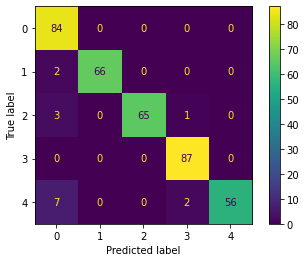

In [ ]:
plot_confusion_matrix(clf, x_test.toarray(), y_test)  
# plt.show()
plt.savefig('confusion_matrix_rf.pdf')

## Decision Tree

In [ ]:
decision = DecisionTreeClassifier()
decision.fit(x_train.toarray(), y_train)
y_pred = decision.predict(x_test.toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84        84
           1       0.81      0.81      0.81        68
           2       0.87      0.84      0.85        69
           3       0.88      0.97      0.92        87
           4       0.84      0.71      0.77        65

    accuracy                           0.84       373
   macro avg       0.84      0.84      0.84       373
weighted avg       0.84      0.84      0.84       373



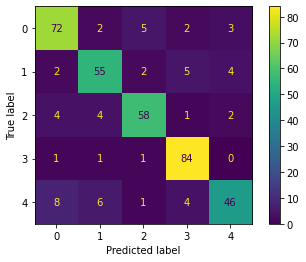

In [ ]:
plot_confusion_matrix(decision, x_test.toarray(), y_test)  
# plt.show()
plt.savefig('confusion_matrix_dt.pdf')

# Inference

In [ ]:
test_df = pd.read_csv('BBC News Test.csv')

In [ ]:
sample_news = list(test_df['Text'].values)[0:5]
sample_news

['qpr keeper day heads for preston queens park rangers keeper chris day is set to join preston on a month s loan.  day has been displaced by the arrival of simon royce  who is in his second month on loan from charlton. qpr have also signed italian generoso rossi. r s manager ian holloway said:  some might say it s a risk as he can t be recalled during that month and simon royce can now be recalled by charlton.  but i have other irons in the fire. i have had a  yes  from a couple of others should i need them.   day s rangers contract expires in the summer. meanwhile  holloway is hoping to complete the signing of middlesbrough defender andy davies - either permanently or again on loan - before saturday s match at ipswich. davies impressed during a recent loan spell at loftus road. holloway is also chasing bristol city midfielder tom doherty.',
 'software watching while you work software that can not only monitor every keystroke and action performed at a pc but also be used as legally bin

In [ ]:
def classify(text, classifier):
  SW = list(response['words'])
  text = ' '.join([word for word in text.split() if word not in (SW)])
  stemmer = SnowballStemmer('english')
  text = ' '.join([stemmer.stem(y) for y in text.split()])
  vectorize_text = tfidf.transform([text])
  pred = classifier.predict(vectorize_text.toarray())
  return le.inverse_transform(pred)[0]

In [ ]:
for article in sample_news:
  pred = classify(article, clf)
  print(f'{article[0:150]}...\nCategory:{pred}\n')

qpr keeper day heads for preston queens park rangers keeper chris day is set to join preston on a month s loan.  day has been displaced by the arrival...
Category:sport

software watching while you work software that can not only monitor every keystroke and action performed at a pc but also be used as legally binding e...
Category:tech

d arcy injury adds to ireland woe gordon d arcy has been ruled out of the ireland team for saturday s six nations clash against scotland in murrayfiel...
Category:sport

india s reliance family feud heats up the ongoing public spat between the two heirs of india s biggest conglomerate  reliance group  has spilled over ...
Category:business

boro suffer morrison injury blow middlesbrough midfielder james morrison has been ruled out for up to eight weeks after an operation on tuesday.  the ...
Category:sport

